In [2]:
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import seaborn as sns

## ガウス過程

### RBFカーネルの確認

In [3]:
# RBFカーネル
def kgauss(params=[1.0, 1.0]):
    theta1, theta2 = params
    return lambda x1, x2: theta1 * np.exp(- np.sum((x1 - x2) ** 2, axis=0) / theta2)

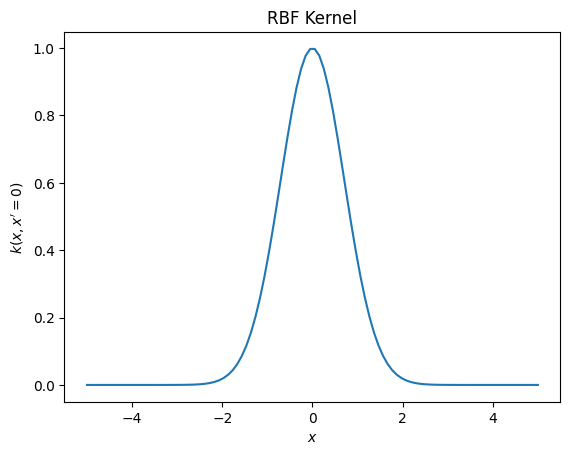

In [4]:
x1 = np.linspace(-5, 5, 100).reshape([-1, 1])
x2 = np.zeros_like(x1)
y = [kgauss()(x, 0) for x in x1]

fig, ax = plt.subplots()
ax.plot(x1, y)
ax.set_xlabel('$x$')
ax.set_ylabel('$k(x, x\'=0)$')
ax.set_title('RBF Kernel')
plt.show()

### ガウス過程からのサンプリング

In [5]:
# カーネル行列
def kernel_matrix(xx, kernel):
    n = xx.shape[0]
    K = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            K[i, j] = kernel(xx[i], xx[j])
    return K

<Axes: >

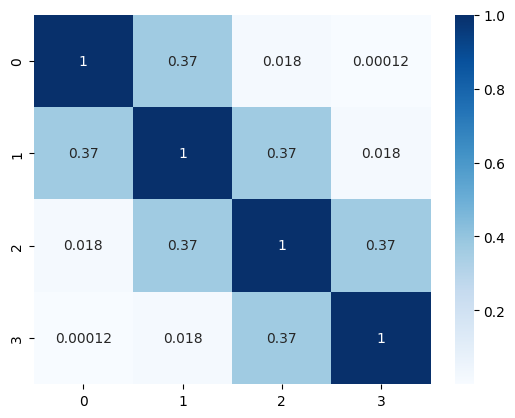

In [6]:
xx_1 = np.linspace(1, 4, 4).reshape([-1, 1])
K_1 = kernel_matrix(xx_1, kgauss())
sns.heatmap(K_1, annot=True, cmap='Blues')

In [7]:
sample_1 = np.random.normal(size=(1,4))
L_1 = np.linalg.cholesky(K_1)
yy_1 = L_1 @ sample_1.T
print(yy_1)

[[-0.82039404]
 [-1.23503929]
 [-0.13607899]
 [ 0.20114147]]


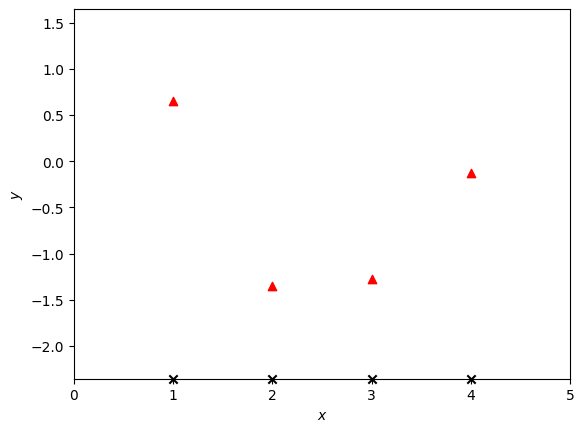

In [8]:
# ガウス過程からのサンプリング
sample_1 = np.random.normal(size=(1,4))
L_1 = np.linalg.cholesky(K_1)
yy_1 = L_1 @ sample_1.T

fig, ax = plt.subplots()
ax.scatter(xx_1, yy_1, marker='^', color='red')
ax.scatter(xx_1, np.ones_like(xx_1)*yy_1.min()-1, marker='x', color='black', clip_on=False)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_ylim(yy_1.min()-1, yy_1.max() + 1)
ax.set_xlim(0, 5)
plt.show()

In [9]:
def plot_sample_heatmap(xx, yy, K):
    fig, axes = plt.subplots(1,2, figsize=(8, 4))

    axes[0].scatter(xx, yy, marker='^', color='red')
    axes[0].scatter(xx, np.ones_like(xx)*yy.min()-1, marker='x', color='black', clip_on=False)
    axes[0].set_xlabel('$x$')
    axes[0].set_ylabel('$y$')
    axes[0].set_ylim(yy.min()-1, yy.max() + 1)
    axes[0].set_xlim(0, 5)
    axes[0].set_aspect('equal')

    sns.heatmap(K, annot=False, cmap='Blues', ax=axes[1])
    axes[1].set_aspect('equal')

    plt.show()

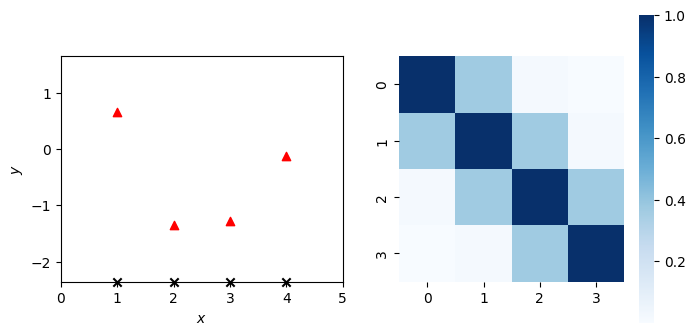

In [10]:
plot_sample_heatmap(xx_1, yy_1, K_1)

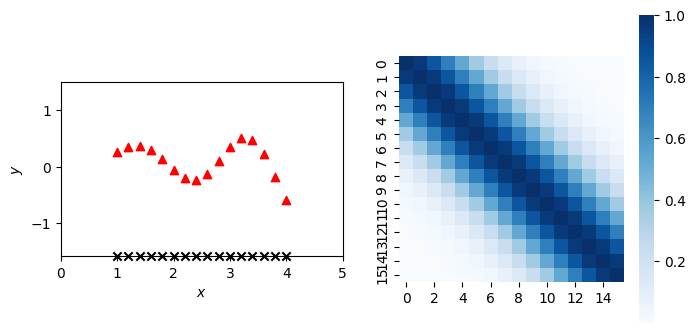

In [11]:
xx_2 = np.linspace(1, 4, 16).reshape([-1, 1])
K_2 = kernel_matrix(xx_2, kgauss())
sample_2 = np.random.normal(size=(1,16))
L_2 = np.linalg.cholesky(K_2)
yy_2 = L_2 @ sample_2.T

plot_sample_heatmap(xx_2, yy_2, K_2)

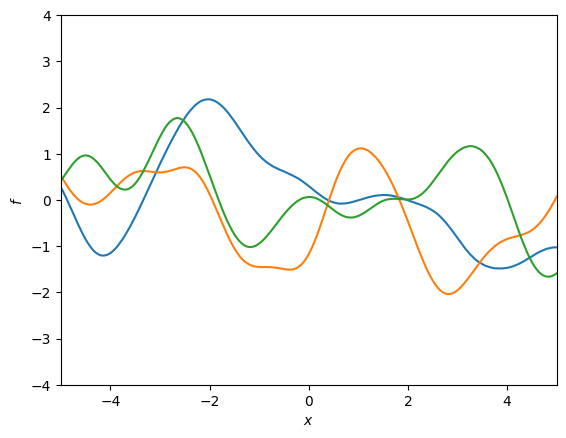

In [12]:
# 1次元の平均0のガウス過程からのサンプリング
def sample_1d(kernel, n_samples, n_points, epsilon = 1e-6):
    xx = np.linspace(-5, 5, n_points).reshape([-1, 1])
    K = kernel_matrix(xx, kernel)
    K_stable = K + epsilon * np.eye(K.shape[0]) # 対角成分に小さな値を加えて計算を安定化(正定値になるようにする)
    sample = np.random.normal(size=(n_samples, n_points))
    # L = np.linalg.cholesky(K)
    L = np.linalg.cholesky(K_stable)
    yy = L @ sample.T
    return xx, yy

xx_1d, yy_1d = sample_1d(kgauss(), n_samples=3, n_points=201)

fig, ax = plt.subplots()
for i in range(yy_1d.shape[1]):
    ax.plot(xx_1d, yy_1d[:, i])
ax.set_xlabel('$x$')
ax.set_ylabel('$f$')
ax.set_xlim(-5, 5)
ax.set_ylim(-4, 4)
plt.show()

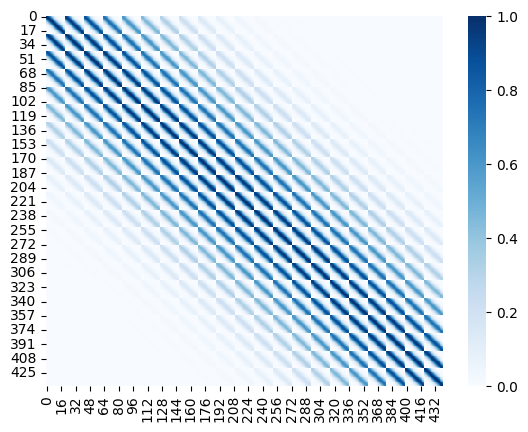

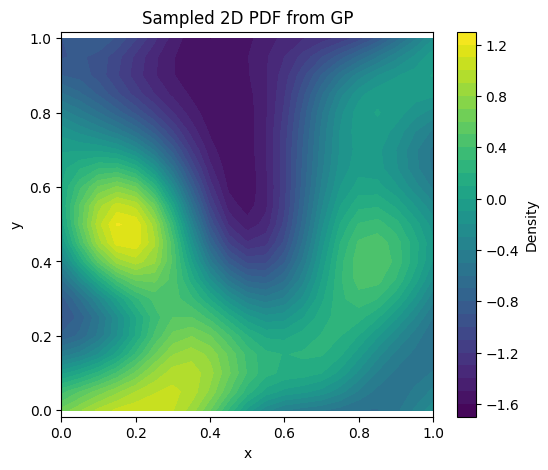

In [13]:
# 2次元の平均0のガウス過程からのサンプリング
def sample_2d(kernel, n_samples, n_points, epsilon = 1e-6):
    xx1 = np.linspace(0, 1, n_points)
    xx2 = np.linspace(0, 1, n_points)
    XX1, XX2 = np.meshgrid(xx1, xx2)
    grid_points = np.hstack([XX1.reshape(-1, 1), XX2.reshape(-1, 1)])
    K = kernel_matrix(grid_points, kernel)
    K_stable = K + epsilon * np.eye(K.shape[0]) # 対角成分に小さな値を加えて計算を安定化(正定値になるようにする)
    sns.heatmap(K_stable, cmap='Blues')

    sample = np.random.normal(size=(n_samples, grid_points.shape[0]))
    # L = np.linalg.cholesky(K)
    L = np.linalg.cholesky(K_stable)
    yy_2d = L @ sample.T

    return grid_points, yy_2d

n_points = 21
n_samples = 1
params = [1.0, 0.04/0.5]  # RBFカーネルのパラメータ
grid_points_2d, yy_2d = sample_2d(kgauss(params), n_samples, n_points)
fig = go.Figure(data=go.Surface(
    z=yy_2d.reshape(n_points, n_points), 
    x=grid_points_2d[:, 0].reshape(n_points, n_points), 
    y=grid_points_2d[:, 1].reshape(n_points, n_points), 
    colorscale='viridis'))
fig.update_layout(scene=dict(xaxis_title='x1', yaxis_title='x2', zaxis_title='f'), width=700, height=700)
fig.show()

# 可視化
plt.figure(figsize=(6, 5))
plt.contourf(grid_points_2d[:, 0].reshape(n_points, n_points), 
             grid_points_2d[:, 1].reshape(n_points, n_points), 
             yy_2d.reshape(n_points, n_points), 
             levels=30, cmap='viridis')
plt.colorbar(label='Density')
plt.title("Sampled 2D PDF from GP")
plt.xlabel("x")
plt.ylabel("y")
plt.axis('equal')
plt.show()

## ガウス過程とカーネル

In [14]:
class MyGP:
    def __init__(self, kernel: str, params: list = None) -> None:
        self.kernel_name = kernel
        self.params = params
        if self.kernel_name == 'linear':
            self.kernel_func = self._klinear()
        elif self.kernel_name == 'rbf':
            self.kernel_func = self._kgauss()
        elif self.kernel_name == 'exp':
            self.kernel_func = self._kexp()
        elif self.kernel_name == 'periodic':
            self.kernel_func = self._kperiodic()
        elif self.kernel_name == 'matern3':
            self.kernel_func = self._kmatern3()
        elif self.kernel_name == 'matern5':
            self.kernel_func = self._kmatern5()
    
    def kernel_matrix(self, xx, epsilon=1e-6):
        n = xx.shape[0]
        K = np.zeros((n, n))
        for i in range(n):
            for j in range(n):
                K[i, j] = self.kernel_func(xx[i], xx[j])
        K_stable = K + epsilon * np.eye(K.shape[0])
        return K_stable
    
    def sample(self, xlim=[0,1], ylim=None, n_samples=1, n_points=21):
        if ylim is None:
            grid_points = np.linspace(xlim[0], xlim[1], n_points).reshape([-1, 1])
        else:
            xx1 = np.linspace(xlim[0], xlim[1], n_points)
            xx2 = np.linspace(ylim[0], ylim[1], n_points)
            XX1, XX2 = np.meshgrid(xx1, xx2)
            grid_points = np.hstack([XX1.reshape(-1, 1), XX2.reshape(-1, 1)])
        K_stable = self.kernel_matrix(grid_points)
        sample = np.random.normal(size=(n_samples, grid_points.shape[0]))
        L = np.linalg.cholesky(K_stable)
        yy = L @ sample.T
        return grid_points, yy
    
    def plot_sample_heatmap_1d(self, xlim=[0,1], n_samples=4, n_points=101, epsilon=1e-6):
        grid_points, yy = self.sample(xlim, None, n_samples, n_points)
        K_stable = self.kernel_matrix(grid_points, epsilon)

        fig, axes = plt.subplots(1, 2, figsize=(8, 4))
        for i in range(n_samples):
            axes[0].plot(grid_points, yy[:, i])
        axes[0].set_xlabel('$x$')
        axes[0].set_ylabel('$f$')
        axes[0].set_xlim(xlim)
        axes[0].set_ylim(-4, 4)
        axes[0].set_aspect('equal')
        sns.heatmap(K_stable, annot=False, cmap='Blues', ax=axes[1])
        axes[1].set_aspect('equal')
        plt.show()

    def _klinear(self):
        return lambda x1, x2: np.dot(x1, x2) + 1
    
    def _kgauss(self):
        if self.params is None:
            theta1, theta2 = 1.0, 1.0
        else:
            theta1, theta2 = self.params
        return lambda x1, x2: theta1 * np.exp(- np.sum((x1 - x2) ** 2, axis=0) / theta2)
    
    def _kexp(self):
        if self.params is None:
            theta1 = 1.0
        else:
            theta1 = self.params
        return lambda x1, x2: np.exp(- np.linalg.norm(x1 - x2) / theta1)
    
    def _kperiodic(self):
        if self.params is None:
            theta1, theta2 = 1.0, 1.0
        else:
            theta1, theta2 = self.params
        return lambda x1, x2: np.exp(theta1 * np.cos(np.linalg.norm(x1 - x2) / theta2))

    def _kmatern3(self):
        if self.params is None:
            theta = 1.0
        else:
            theta = self.params
        return lambda x1, x2: (1 + np.sqrt(3) * np.linalg.norm(x1 - x2) / theta) * np.exp(-np.sqrt(3) * np.linalg.norm(x1 - x2) / theta)
    
    def _kmatern5(self):
        if self.params is None:
            theta = 1.0
        else:
            theta = self.params
        return lambda x1, x2: (1 + np.sqrt(5) * np.linalg.norm(x1 - x2) / theta + 5 * np.linalg.norm(x1 - x2)**2 / (3 * theta**2)) * np.exp(-np.sqrt(5) * np.linalg.norm(x1 - x2) / theta)

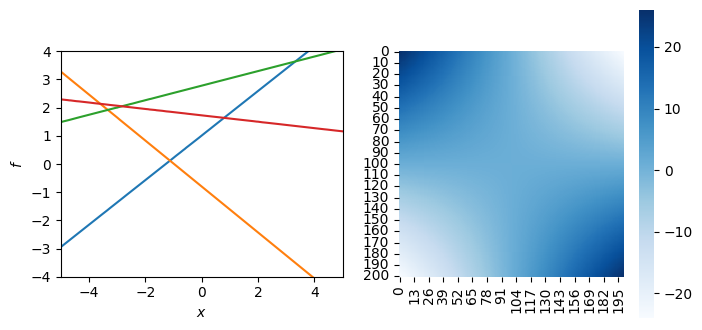

In [15]:
linear = MyGP(kernel='linear')
linear.plot_sample_heatmap_1d(xlim=[-5, 5], n_samples=4, n_points=201)

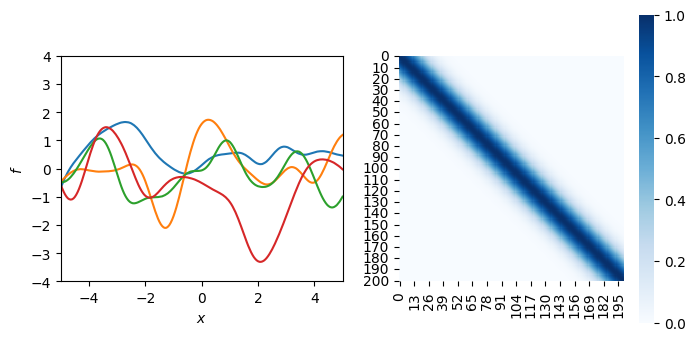

In [16]:
rbf = MyGP(kernel='rbf')
rbf.plot_sample_heatmap_1d(xlim=[-5, 5], n_samples=4, n_points=201)

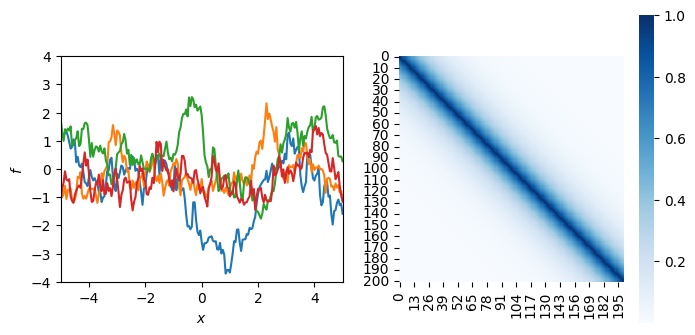

In [17]:
exp = MyGP(kernel='exp')
exp.plot_sample_heatmap_1d(xlim=[-5, 5], n_samples=4, n_points=201)

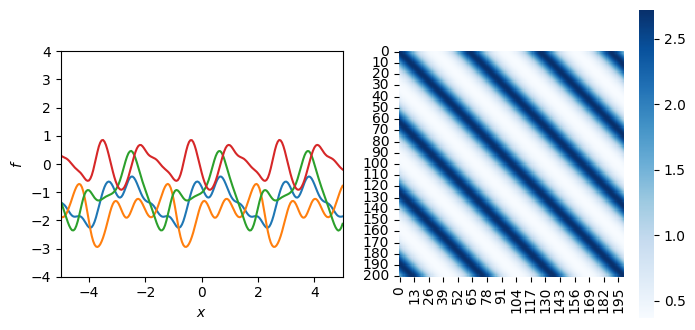

In [18]:
periodic = MyGP(kernel='periodic', params=[1.0, 0.5])
periodic.plot_sample_heatmap_1d(xlim=[-5, 5], n_samples=4, n_points=201)

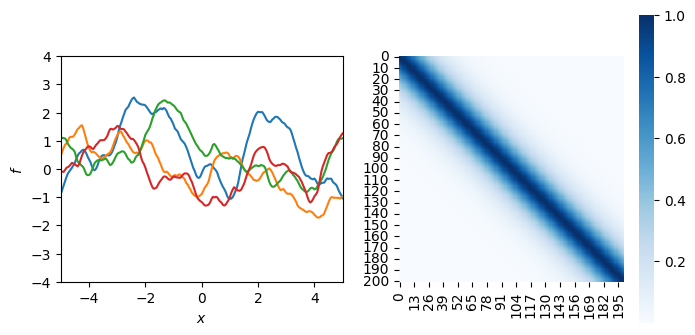

In [19]:
matern3 = MyGP(kernel='matern3')
matern3.plot_sample_heatmap_1d(xlim=[-5, 5], n_samples=4, n_points=201)

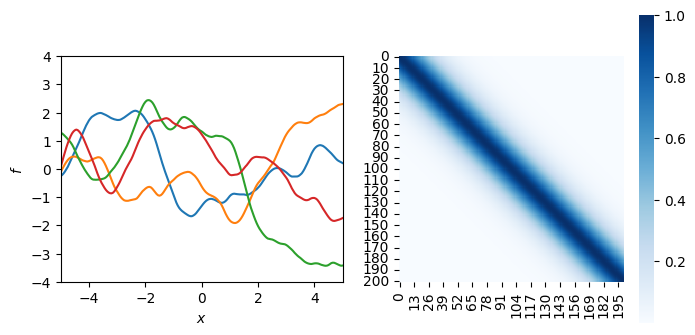

In [20]:
matern5 = MyGP(kernel='matern5')
matern5.plot_sample_heatmap_1d(xlim=[-5, 5], n_samples=4, n_points=201)